In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.io import read_image
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt

### Load a pre-trained ResNet50 classifier network with DEFAULT weights

In [2]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

### Preprocess the image

In [3]:
# Load image
# Load your image
img_path = "tiger.jpg"
#img = Image.open(img_path).convert("RGB")
img = read_image(img_path)

In [4]:
# Initialize the Weight Transforms
weights = models.ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

# Apply it to the input image
img_transformed = preprocess(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

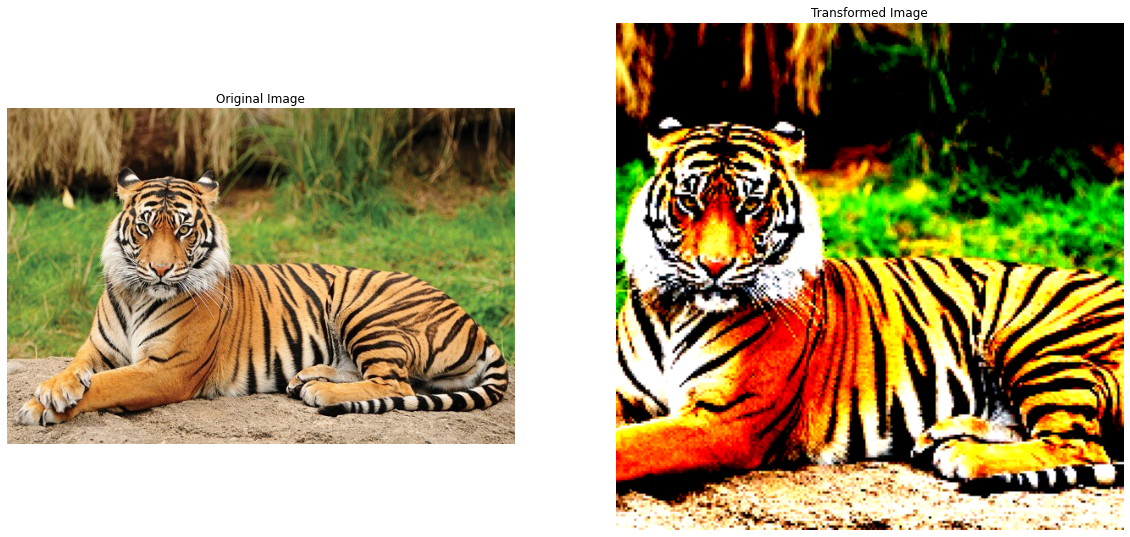

In [5]:
# Visualize the original image
plt.figure(figsize=(20,20))

# Visualize the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
# Assuming img is a PyTorch tensor, convert it to a NumPy array for display
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis('off')

# Visualize the transformed image
plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(img_transformed.numpy().transpose(1, 2, 0))  # Transpose the tensor to (H, W, C) for display
plt.axis('off')

### Turn the model into evaluation mode

In [6]:
# Set model to eval mode
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Check if model correctly classifies image

In [7]:
# Turn image into batch (dimensions setting so it corresponds to proper dimensions that batch needs to have HxWxCxN)
batch = img_transformed.unsqueeze(0)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = resnet50.to(device)
batch = batch.to(device)

In [9]:
# Use the model and print the predicted category
prediction = resnet50(batch).squeeze(0).softmax(0) # 0 here means that squeeze and softmax are applied to the dimension 0
print("Number of classes: ", prediction.shape)
print("Should sum up to 1.00 ?: ", torch.sum(prediction))
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print("Predicted class is: ", category_name)
print("Probability of predicted class (in %): ", 100 * score)

Number of classes:  torch.Size([1000])
Should sum up to 1.00 ?:  tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)
Predicted class is:  tiger
Probability of predicted class (in %):  42.83302426338196


### Display the layers of ResNet50

In [10]:
train_nodes, eval_nodes = get_graph_node_names(resnet50)

In [11]:
eval_nodes

['x',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.relu_1',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.add',
 'layer1.0.relu_2',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.relu_1',
 'layer1.1.conv3',
 'layer1.1.bn3',
 'layer1.1.add',
 'layer1.1.relu_2',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.relu',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer1.2.relu_1',
 'layer1.2.conv3',
 'layer1.2.bn3',
 'layer1.2.add',
 'layer1.2.relu_2',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.relu_1',
 'layer2.0.conv3',
 'layer2.0.bn3',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.0.add',
 'layer2.0.relu_2',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer2.1.relu_1',
 'layer2.

### Feature Maps Visualization

In [12]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(resnet50.children())
# Which layers we want
layers = [1,2,4]
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter = counter + 1
        if counter in layers:
            print("Layer loaded: ", counter)
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential: # Sequential
        for j in range(len(model_children[i])): # Bottleneck
            for child in model_children[i][j].children(): # Real
                if type(child) == nn.Conv2d:
                    counter = counter + 1
                    if counter in layers:
                        print("Layer loaded: ", counter)
                        model_weights.append(child.weight)
                        conv_layers.append(child)

Layer loaded:  1
Layer loaded:  2
Layer loaded:  4


In [13]:
conv_layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)]

In [14]:
outputs = []
names = []
for layer in conv_layers:
    batch = layer(batch)
    outputs.append(batch)
    names.append(str(layer))

In [15]:
for feature_map in outputs:
    # batch size, number of channels, height, width
    print(feature_map.shape)

torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])


In [16]:
# Convert 3D tensor to 2D
processed = []
for feature_map in outputs:
    # Take first image from batch (0) and take 20th feature map channel
    feature_map = feature_map[0,20,:,:]
    processed.append(feature_map.data.cpu().numpy())

In [17]:
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)


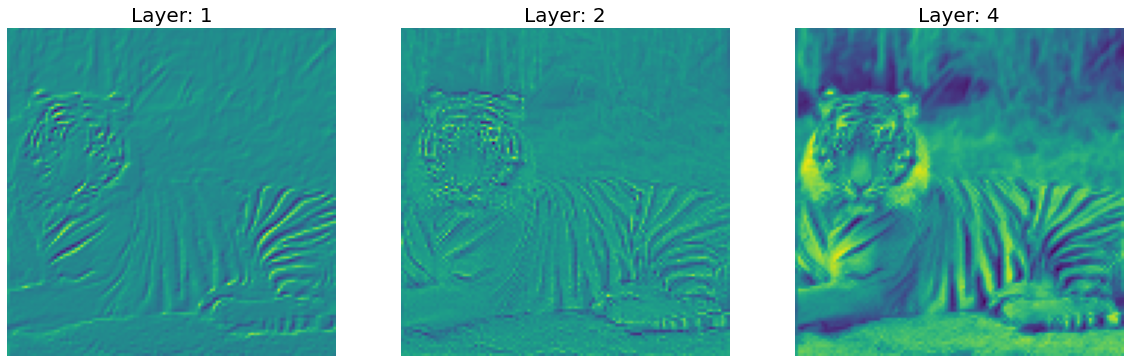

In [18]:
fig = plt.figure(figsize=(20, 20))
for i in range(len(processed)):
    a = fig.add_subplot(1, 3, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title('Layer: ' + str(layers[i]), fontsize=20)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

#### Describe the change in behavior of the filters going deeper in the network; what are the main focus of shallow layers and deeper layers?

The first observation that can be seen as we move from shallow layers to deeper layers is that in the shallow layers (layer1, layer2) the features that are visible to the network are mainly the intensity changes. In this example of the tiger we can see that at layers 1 and 2 we are basically able to view the stripes on the tigers body. We believe that in these layers the network is able to learn about the general featurs like the edges and corners in the image. Maybe in these layers the learning may be focused towards understanding patterns formed by the combination of these various general features and how they relate to a certain class.

In the deeper layer it becomes harder to visually inspect what the network is understanding. As can be seen above at layer 4 visually we can see the entire tiger as a whole, but not all the features of the tiger is visible in this layer but instead we are only able to see rthe prominent features in the entire image. At this layer we are able to have a better understanding of the body shape of the animal, its posture etc. We can speculate that at the deeper layers the network is only trying to learn a general understanding of the entire input as a whole and not the individual edges or corners which were learnt in the shallower layers. 

So the network may initially be learning the low level features in the input at the shallow layers and as we go deeper the network combines this low level information with a more generalised understanding of the whole input data. This combined information then aides in making a decision on how to categorize the input image.